In [5]:
# Math stuff
import numpy as np
# For handling dataset
import pandas as pd
# For plotting
import matplotlib.pyplot as plt
# Model used as a benchmark
from sklearn.svm import OneClassSVM
# For undersampling
from imblearn.under_sampling import RandomUnderSampler
# metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

In [6]:
df = pd.read_csv('creditcard.csv')
df = df[['V11', 'V13', 'V15', 'Class']]

In [137]:
X, y = df.iloc[:,:-1].copy(), df.iloc[:,-1:].copy()

In [148]:
y.Class.loc[y.Class == 1] = -1
y.Class.loc[y.Class == 0] = 1

In [149]:
isLegit = y.Class == 1

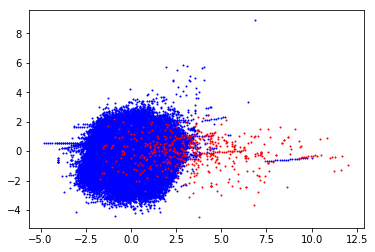

In [150]:
plt.scatter(X[isLegit].V11, X[isLegit].V15, s=1, c='b')
plt.scatter(X[~isLegit].V11, X[~isLegit].V15, s=1, c='r')
plt.show()

In [184]:
rus = RandomUnderSampler(random_state=0, ratio={1:400*20, -1:400}, return_indices=True)

In [186]:
X_resampled, y_resampled, idxs = rus.fit_sample(X, y)
X_resampled = pd.DataFrame(X_resampled)
X_resampled.columns = ['V11', 'V13', 'V15']

In [187]:
params = { 'kernel':['linear', 'poly', 'rbf', 'sigmoid'], \
    'nu':[.1, 0.261, .5, .75, .8] }

In [107]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

In [188]:
scoring = {'AUC':make_scorer(average_precision_score)}

In [189]:
# Create a classifier object with the classifier and parameter candidates
clf = GridSearchCV(estimator=OneClassSVM(), param_grid=params, n_jobs=-1, scoring=scoring, refit='AUC')

In [190]:
clf.fit(X_resampled, y_resampled)

GridSearchCV(cv=None, error_score='raise',
       estimator=OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto', kernel='rbf',
      max_iter=-1, nu=0.5, random_state=None, shrinking=True, tol=0.001,
      verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'nu': [0.1, 0.261, 0.5, 0.75, 0.8]},
       pre_dispatch='2*n_jobs', refit='AUC', return_train_score=True,
       scoring={'AUC': make_scorer(average_precision_score)}, verbose=0)

In [191]:
clf.best_estimator_

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto', kernel='rbf',
      max_iter=-1, nu=0.1, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [26]:
clf = OneClassSVM(nu=0.261, gamma=0.05)

In [27]:
clf.fit(X1)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.05, kernel='rbf',
      max_iter=-1, nu=0.261, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [83]:
xmin, xmax = min(X.V11), max(X.V11)
ymin, ymax = min(X.V15), max(X.V15)

xx, yy = np.mgrid[xmin:xmax:.1, ymin:ymax:.1]

In [84]:
zz = np.c_[xx.ravel(), yy.ravel()]

In [163]:
Z = clf.best_estimator_.decision_function(zz)

In [164]:
Z = np.reshape(Z, xx.shape)

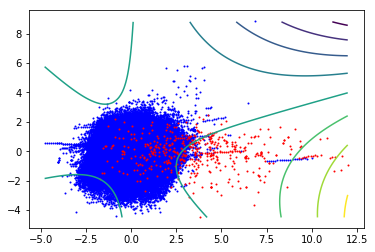

In [166]:
plt.contour(xx, yy, Z)
plt.scatter(X[isLegit].V11, X[isLegit].V15, s=1, c='b')
plt.scatter(X[~isLegit].V11, X[~isLegit].V15, s=1, c='r')

plt.show()

In [192]:
y_pred = clf.predict(X.iloc[~idxs])
y_true = y.iloc[~idxs]

In [193]:
precision, recall, _ = precision_recall_curve(y_pred, y_true)
auc = average_precision_score(y_true=y_true, y_score=y_pred)

print 'precision %.7f' % precision[1]
print 'recall %.7f' % recall[1]
print 'auc %.7f' % auc

precision 0.9271231
recall 0.9988435
auc 0.9987890


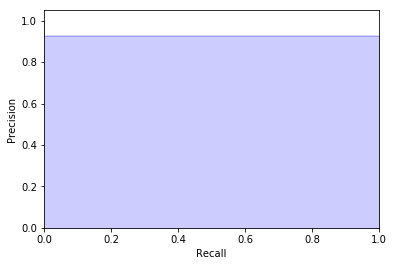

In [194]:
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()